In [1]:
"""
Script for formatting and visualizing the MIT-Arrhythmia database
Steps:
    1. Download the ZIP database from https://alpha.physionet.org/content/mitdb/1.0.0/
    2. Open it with a zip-opener (WinZip, 7zip).
    3. Extract the folder of the same name (named 'mit-bih-arrhythmia-database-1.0.0') to the same folder as this script.
    4. Run this script.
    
Modified from https://github.com/neuropsychology/NeuroKit/blob/dev/data/mit_arrhythmia/download_mit_arrhythmia.py
"""
import pandas as pd
import numpy as np
import wfdb
import os
import neurokit2 as nk
import copy as cp
from collections import Counter
import random

In [2]:
np.random.seed(seed=0)
random.seed(0)

In [3]:
def read_file_with_metadata(file, participant, selected_labels):
    """Utility function
    """
    # Get signal
    data = pd.DataFrame({"ECG": wfdb.rdsamp(file[:-4])[0][:, 0]})
    data["Participant"] = "MIT-Arrhythmia_%.2i" %(participant)
    data["Sample"] = range(len(data))
    data["Sampling_Rate"] = 360
    data["Database"] = "MIT-Arrhythmia-x" if "x_mitdb" in file else "MIT-Arrhythmia"

    # getting annotations
    anno = wfdb.rdann(file[:-4], 'atr')
    symbols = [x for x in anno.symbol if x in selected_labels]
    anno = np.unique(anno.sample[np.isin(anno.symbol, selected_labels)])
    anno = pd.DataFrame({"Rpeaks": anno, "Symbol": symbols})
    anno["Participant"] = "MIT-Arrhythmia_%.2i" %(participant)
    anno["Sampling_Rate"] = 360
    anno["Database"] = "MIT-Arrhythmia-x" if "x_mitdb" in file else "MIT-Arrhythmia"

    return data, anno

In [4]:
def read_file(file, participant, selected_labels):
    """
    Reads the original data files from the database and extracts the raw signal
    and the beat annotation labels for the RPeaks (vertical line in ECG readings).
    The signals are a half-hour long recording using a sampling rate of 360 per particpant (n=48)
    The specific explaination for the annotation symbols are found here
    https://archive.physionet.org/physiobank/annotations.shtml
    "+" is the start of the reading
    """
    # Get signal
    data = pd.DataFrame({"ECG": wfdb.rdsamp(file[:-4])[0][:, 0]})
    # getting annotations
    anno = wfdb.rdann(file[:-4], 'atr')
    symbols = [x for x in anno.symbol if x in selected_labels]
    anno = np.unique(anno.sample[np.isin(anno.symbol, selected_labels)])
    anno = pd.DataFrame({"Rpeaks": anno, "Symbol": symbols})

    return data, anno

In [5]:
def chunks(lst, n):
    """Yield successive n-sized chunks from list."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [6]:
def create_intervals(data_files, sampling_rate, selected_labels):
    """
    This involves splitting the hour long recording into 10 second segments 
    and creating a singular label for the classification of that segment
    For our purposes, we are selecting the majority non-normal annotation as the label
    [N, N, N, A, A, A, A, A, F] would select 'A' as the label for the segment
    
    If the given sequence is not the correct length, pad with zeros
    """
    dfs_ecg = []
    dfs_labels = []
    for participant, file in enumerate(data_files):
        print("Participant: " + str(participant + 1) + "/" + str(len(data_files)))

        data, anno = read_file(file, participant, selected_labels)
        segments = list(chunks(data["ECG"], sampling_rate*10))
        labels = []
        for i, segment in enumerate(segments):
            segments[i] = segment.to_numpy()
            if len(segment) != sampling_rate*10:
                segments[i] = np.pad(segment, (0, sampling_rate*10 - len(segment)), 'constant')
            start = i*sampling_rate*10 
            end = start+sampling_rate*10 
            idx = np.where((anno["Rpeaks"]<end) & (anno["Rpeaks"] >= start))
            beat_annotations = anno.loc[idx]['Symbol']
            beat_annotations_copy = cp.deepcopy(beat_annotations)
            while "N" in beat_annotations_copy:
                beat_annotations_copy.remove("N")
            if len(beat_annotations_copy) == 0:
                label = "N"
            else:
                label = Counter(beat_annotations).most_common(1)[0][0]
            labels.append(label)
        dfs_ecg.extend(segments)
        dfs_labels.extend(labels)

        # Store additional recording if available
        if "x_" + file.replace("mit-bih-arrhythmia-database-1.0.0/", "") in os.listdir("mit-bih-arrhythmia-database-1.0.0/x_mitdb/"):
            print("  - Additional recording detected.")
            data, anno = read_file("mit-bih-arrhythmia-database-1.0.0/x_mitdb/" + "x_" + file.replace("mit-bih-arrhythmia-database-1.0.0/", ""), participant, selected_labels)
            # Store with the rest
            segments = list(chunks(data["ECG"], sampling_rate*10))
            labels = []
            for i, segment in enumerate(segments):
                segments[i] = segment.to_numpy()
                if len(segment) != sampling_rate*10:
                    segments[i] = np.pad(segment, (0, sampling_rate*10 - len(segment)), 'constant')
                start = i*sampling_rate*10 
                end = start+sampling_rate*10 
                idx = np.where((anno["Rpeaks"]<end) & (anno["Rpeaks"] >= start))
                beat_annotations = anno.loc[idx]['Symbol']
                beat_annotations_copy = cp.deepcopy(beat_annotations)
                while "N" in beat_annotations_copy:
                    beat_annotations_copy.remove("N")
                if len(beat_annotations_copy) == 0:
                    label = "N"
                else:
                    label = Counter(beat_annotations).most_common(1)[0][0]
                labels.append(label)
            dfs_ecg.extend(segments)
            dfs_labels.extend(labels)



    # Save
    dfs_ecg = np.stack(dfs_ecg, axis=0)
    dfs_labels = np.array(dfs_labels)
    np.save("ECGs", dfs_ecg, allow_pickle=True)
    np.save("labels", dfs_labels, allow_pickle=True)
    return dfs_ecg, dfs_labels

In [7]:
def create_MIT_dataset(file_path):
    """
    Create the dataset to be used and partition it into train and test data
    Both a multiclass and binary classification dataset will be created
    Partition will be roughly 75% train, 25% test
    Make sure that labels with low samples are roughly evenly distributed
    Labels will be encoded
    """
    data_files = [file_path + file for file in os.listdir(file_path) if ".npy" in file]
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    y_train_binary = []
    y_test_binary = []
    
    for file in data_files:
        label = int(file[(file.index("_")+1): file.rindex(".")])
        
        if label == 6:
            binary_label = 0 # Normal beat
        else:
            binary_label = 1
        
        signals = np.load(file, allow_pickle=True)
        np.random.shuffle(signals)
        number = len(signals)
        labels = [label]*number
        binary_labels = [binary_label]*number
        
        if number < 100:
            number = number // 2
        else:
            number = number // 4
            
        
        
        X_train.extend(signals[number:])
        y_train.extend(labels[number:])
        X_test.extend(signals[:number])
        y_test.extend(labels[:number])
        y_train_binary.extend(binary_labels[number:])
        y_test_binary.extend(binary_labels[:number])
        
    
    print("Train: ", len(X_train))
    print("Test: ", len(X_test))
    np.save("X_train", np.array(X_train), allow_pickle=True)
    np.save("y_train", np.array(y_train), allow_pickle=True)
    np.save("X_test", np.array(X_test), allow_pickle=True)
    np.save("y_test", np.array(y_test), allow_pickle=True)
    np.save("y_train_binary", np.array(y_train_binary), allow_pickle=True)
    np.save("y_test_binary", np.array(y_test_binary), allow_pickle=True)
    return 

In [8]:
def seperate_refiner_classes(dfs_ecg, dfs_labels):
    """
    Seperates the signals based on their class annotation
    Expected use case it to feed the examples to a refiner to train
    on specific classes of heart disease or conditions
    """
    unique_labels = np.unique(list(dfs_labels))
    for i, label in enumerate(unique_labels):
        idx = np.where(dfs_labels == label)
        dfs_ecg_label = dfs_ecg[idx]
        np.save("classes/class_"+str(i), dfs_ecg_label, allow_pickle=True)
    np.save("unique_labels", unique_labels, allow_pickle=True)
    return

In [9]:
def seperate_refiner_binary_classes(dfs_ecg, dfs_labels):
    """
    Seperates the signals based on normal vs abnormal heartbeat
    Expected use case it to feed the examples to a refiner to train
    on general normal or abnormal heartbeats
    """
    norm_idx = np.where(dfs_labels == "N")
    ab_idx = np.where(dfs_labels != "N")
    dfs_ecg_normal = dfs_ecg[norm_idx]
    dfs_ecg_abnormal = dfs_ecg[ab_idx]
    np.save("normal", dfs_ecg_normal, allow_pickle=True)
    np.save("abnormal", dfs_ecg_abnormal, allow_pickle=True)
    return

In [10]:
data_files = ["mit-bih-arrhythmia-database-1.0.0/" + file for file in os.listdir("mit-bih-arrhythmia-database-1.0.0") if ".dat" in file]
selected_labels = ['N', 'L', 'R', 'B', 'A', 'a', 'J', 'S', 'V', 'r', 'F', 'e', 'j', 'n', 'E', '/', 'f', 'Q', '?']
dfs_ecg, dfs_labels = create_intervals(data_files, 360, selected_labels)

Participant: 1/48
Participant: 2/48
Participant: 3/48
Participant: 4/48
  - Additional recording detected.
Participant: 5/48
  - Additional recording detected.
Participant: 6/48
  - Additional recording detected.
Participant: 7/48
Participant: 8/48
Participant: 9/48
Participant: 10/48
  - Additional recording detected.
Participant: 11/48
  - Additional recording detected.
Participant: 12/48
  - Additional recording detected.
Participant: 13/48
  - Additional recording detected.
Participant: 14/48
  - Additional recording detected.
Participant: 15/48
  - Additional recording detected.
Participant: 16/48
Participant: 17/48
Participant: 18/48
  - Additional recording detected.
Participant: 19/48
  - Additional recording detected.
Participant: 20/48
Participant: 21/48
Participant: 22/48
  - Additional recording detected.
Participant: 23/48
  - Additional recording detected.
Participant: 24/48
Participant: 25/48
Participant: 26/48
Participant: 27/48
Participant: 28/48
  - Additional recordi

In [11]:
print(len(dfs_ecg))

10068


In [12]:
print(np.unique(list(dfs_labels)))

['/' 'A' 'E' 'F' 'J' 'L' 'N' 'Q' 'R' 'V' 'a' 'f' 'j']


<AxesSubplot:xlabel='label'>

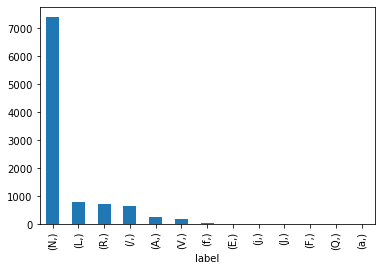

In [13]:
pd.DataFrame({"label": dfs_labels}).value_counts().plot(kind='bar')

In [14]:
pd.DataFrame({"label": dfs_labels}).value_counts()

label
N        7402
L         797
R         715
/         657
A         262
V         172
f          26
E          11
j          11
J           8
F           5
Q           1
a           1
dtype: int64

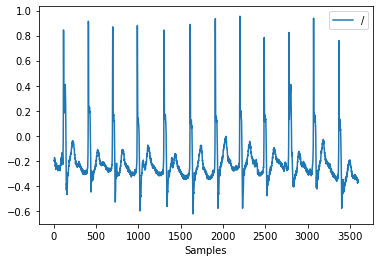

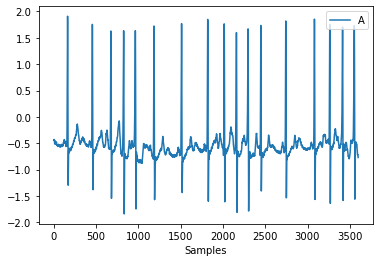

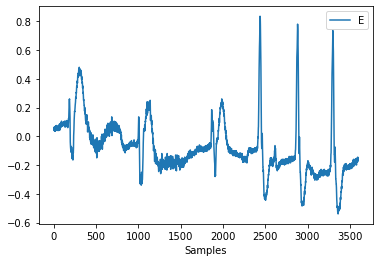

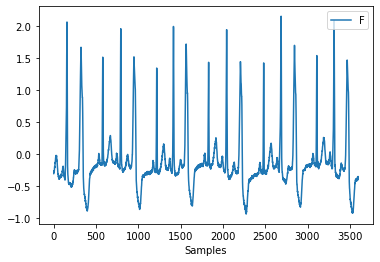

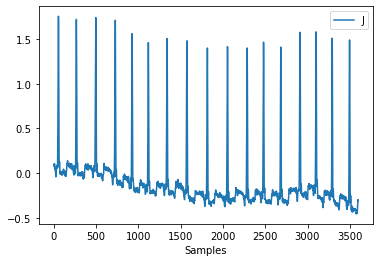

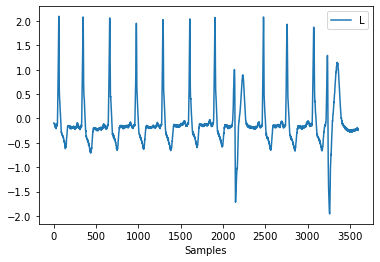

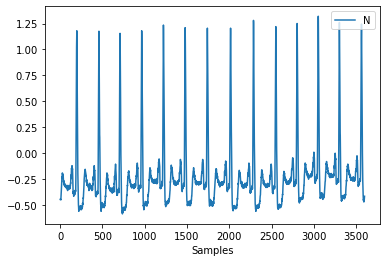

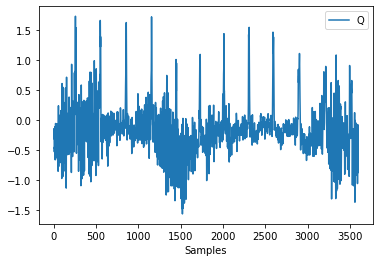

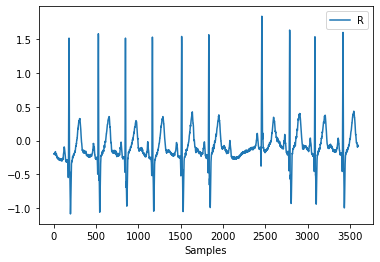

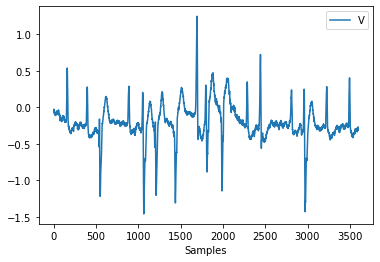

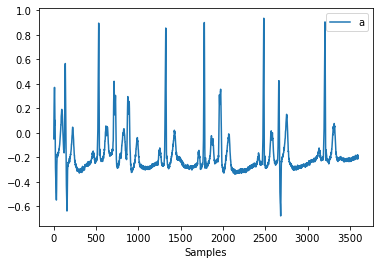

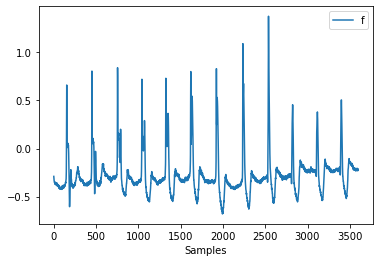

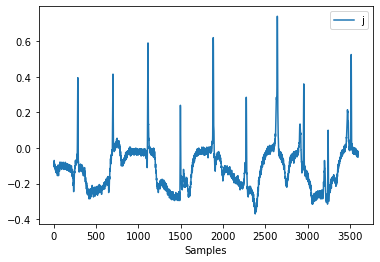

In [15]:
# Quick test
for label in np.unique(list(dfs_labels)):
    signal = dfs_ecg[np.where(dfs_labels == label)[0][0]]
    methods = pd.DataFrame({label: signal})
    nk.signal_plot(methods)

In [16]:
"""
Due to the small number of samples for some classes, we will remove them before partitioning
them into train and test sets
"""
print("Before: ", len(dfs_ecg))
print(pd.DataFrame({"label": dfs_labels}).value_counts())
for label in ["a", "Q"]:
    while label in dfs_labels:
        idx = np.where(dfs_labels == label)[0][0]
        dfs_ecg = np.delete(dfs_ecg, idx, axis=0)
        dfs_labels = np.delete(dfs_labels, idx)
print("After: ", len(dfs_ecg))
pd.DataFrame({"label": dfs_labels}).value_counts()

Before:  10068
label
N        7402
L         797
R         715
/         657
A         262
V         172
f          26
E          11
j          11
J           8
F           5
Q           1
a           1
dtype: int64
After:  10066


label
N        7402
L         797
R         715
/         657
A         262
V         172
f          26
E          11
j          11
J           8
F           5
dtype: int64

In [17]:
print(np.unique(list(dfs_labels)))

['/' 'A' 'E' 'F' 'J' 'L' 'N' 'R' 'V' 'f' 'j']


In [18]:
# This method was used for GECCO '22 paper to get the abnormal dataset
seperate_refiner_binary_classes(dfs_ecg, dfs_labels) 

In [19]:
seperate_refiner_classes(dfs_ecg, dfs_labels)

In [20]:
create_MIT_dataset("./classes/")

Train:  7538
Test:  2528
